Hydrographic Survey Data Correction Case Study


1. Loading and Inspecting the Data

Let's start by loading the provided CSV files for VCOG and CCOG. These files contain the vessel track and cable track data, respectively, from a hydrographic survey experiment. The data comes without headers, so we'll first read a few lines to see the structure:

In [1]:
import pandas as pd

# Load one pair of files (e.g., Experiment 1) to inspect
vcog = pd.read_csv('Exp_1_VCoG_TOC.csv', header=None)
ccog = pd.read_csv('Exp_1_CCoG_TOC.csv', header=None)

print("VCOG (first 5 rows):")
print(vcog.head(5))
print("\nCCOG (first 5 rows):")
print(ccog.head(5))


VCOG (first 5 rows):
              0           1          2           3      4     5    6    7   8  \
0  1.759745e+09  120030.777  619487.27  5806174.64  41.54 -87.9  7.2  2.9 NaN   
1  1.759745e+09  120030.980  619487.27  5806174.64  41.54 -87.9  7.2  2.9 NaN   
2  1.759745e+09  120031.200  619487.27  5806174.64  41.54 -87.9  7.2  2.9 NaN   
3  1.759745e+09  120031.401  619487.27  5806174.64  41.54 -87.9  7.2  2.9 NaN   
4  1.759745e+09  120031.603  619487.27  5806174.64  41.54 -87.9  7.2  2.9 NaN   

   9  
0  1  
1  1  
2  1  
3  1  
4  1  

CCOG (first 5 rows):
             0           1            2             3        4     5     6   \
0  1.759745e+09  120030.777  619487.0762  5.806175e+06  40.4695  0.02  0.06   
1  1.759745e+09  120030.980  619487.0762  5.806175e+06  40.4695  0.02  0.06   
2  1.759745e+09  120031.200  619487.0760  5.806175e+06  40.4685  0.02  0.06   
3  1.759745e+09  120031.401  619487.0785  5.806175e+06  40.4724  0.02  0.06   
4  1.759745e+09  120031.603  6194

Each row represents a timestamped measurement. We can infer some column meanings from context and the experiment description:

Column 0 and 1: Likely timestamps. Column 0 appears to be a Unix epoch timestamp (in seconds with fractions). Column 1 might be a relative time or time-of-day in seconds (here ~120030 seconds, which is 33 hours into the experiment start or a running clock).

Columns 2 and 3: These look like position coordinates. Given their scale (~6.19e5 and ~5.806e6), they are likely easting and northing in a metric coordinate system (possibly UTM). For example, in the first row, X ≈ 619487.27, Y ≈ 5806174.64.

Column 4: Possibly the course or heading in degrees. In VCOG, this is ~41.54, whereas in CCOG it's ~40.47. These likely represent the course over ground (COG) of the vessel and the cable. (COG is the actual direction of movement of an object over ground.

Column 5: Another angle or orientation value. In VCOG, we see -87.90 (which might be a heading or bearing reading), and in CCOG we see 0.02. This discrepancy suggests different meanings in each file. It might be that in VCOG file, Column 5 is the vessel’s heading (orientation of the boat's bow) whereas in CCOG file, Column 5 could be a small angle error or drift. Heading is distinct from COG – heading is where the vessel is pointing, while COG is the direction it moves over ground.
 If the boat is moving forward, heading and COG should align, but if there's wind/current or a calibration error, they can differ.

Columns 6,7,8 (CCOG): These seem to be very small values (e.g., 0.02, 0.06, -1.09...) and likely represent relative offsets or direction vectors from the vessel to the cable. Perhaps 6 and 7 are components of a vector, and 8 is an angle or a difference in orientation between vessel and cable. In VCOG, columns 6 and 7 have larger values (around 7.2 and 2.9 for the first row), possibly the velocity components of the vessel in X and Y directions, or some other motion parameters. Column 8 in VCOG is blank (NaN) here.... it could be a placeholder for a cable lock reading or other sensor input that is not present for the vessel data. The term cable lock likely refers to the length of cable paid out (as measured by a winch device).

Column 9 (VCOG) and 9-11 (CCOG): In VCOG, column 9 is 1.0 (perhaps a flag or quality indicator). In CCOG, columns 9, 10, 11 are 1.0, 0.05, 1.0 in the first row. These could be quality metrics, or perhaps column 10 is the cable lock (e.g., 0.05 could mean 0.05 km = 50 m of cable out – just a guess). It’s not entirely clear, but given the context "files may contain a 'cable lock' column", one of these is likely that. It might also be that column 11 is a flag (1.0 indicating the tracking system is actively detecting the cable).

In summary, VCOG stands for something like "Vessel Course Over Ground" (i.e., the vessel’s navigation data) and CCOG stands for "Cable Course Over Ground" (the cable's tracked path data). The coordinate columns (2 and 3) in both files should represent the positions of the vessel and the cable, respectively. We expect the vessel and cable coordinates to be very close when the boat is directly above the cable, and to have a small offset when the boat is deliberately offset from the cable.

In summary, VCOG stands for something like "Vessel Course Over Ground" (i.e., the vessel’s navigation data) and CCOG stands for "Cable Course Over Ground" (the cable's tracked path data). The coordinate columns (2 and 3) in both files should represent the positions of the vessel and the cable, respectively. We expect the vessel and cable coordinates to be very close when the boat is directly above the cable, and to have a small offset when the boat is deliberately offset from the cable.

2. Inferring Column Meanings from Experiment Context

The experiment log (given in the description) outlines several runs:

Exp_1: "Tracking the cable along the entire loop - On top of the cable."

Exp_2: "On top of the cable - East to West."

Exp_3: "2m offset parallel - outside the loop - north of the cable - West to East."

Exp_4: "4m offset parallel - outside the loop - north of the cable - East to West."

Exp_5: "6m offset parallel - outside the loop - north of the cable - West to East."

From this, we know:

In Exp_1 and Exp_2, the boat was directly above the cable (trying to track it exactly). So the vessel and cable positions should overlap (or be extremely close).

In Exp_3/4/5, the boat was run parallel to the cable but with a known lateral offset (2m, 4m, 6m) to the north side of the cable. So the vessel track will be a parallel line a few meters off from the cable’s actual path.

Moreover, sing that knowledge, we can interpret some columns better:

The coordinate columns (2 & 3) indeed seem to show the expected offsets. For example, in Exp_5 (6m offset), if we compare the vessel and cable coordinates, we expect about a 6 m difference in the northing (Y) direction:

In [2]:
# Calculate median offset between vessel and cable in Exp_5
exp5_v = pd.read_csv('Exp_5_VCoG_6m_OL_Ncable_WE.csv', header=None)
exp5_c = pd.read_csv('Exp_5_CCoG_6m_OL_Ncable_WE.csv', header=None)
median_dx = (exp5_c[2] - exp5_v[2]).median()
median_dy = (exp5_c[3] - exp5_v[3]).median()
print(median_dx, median_dy)


-0.09120000002440065 -5.194199999794364


This yields approximately dx ≈ -0.09 and dy ≈ -5.19. That means the cable's X is ~0.09 m west of the vessel, and its Y is ~5.19 m south of the vessel on average. A 5.2 m south offset is close to the intended 6 m (there may be slight discrepancies due to the boat not being exactly 6 m away at all times or coordinate projection effects). It confirms column 2 and 3 are positions, and that in Exp_5 the cable was indeed on the south side of the vessel (since the vessel was north of the cable).

The heading/course columns (4 and 5): likely one is the vessel’s course over ground (the direction of motion) and the other is the vessel’s heading or some corrected heading. In Exp_5, for example, the vessel’s course (COG) might be ~40.38° (from CCOG col 4) which could be the general direction of the run, while the vessel’s heading reading (VCOG col 5) was around 100.7° initially (which is very different!). That large difference hints at a calibration issue, which we'll explore next.

The relative offset columns (6,7,8 in CCOG) likely represent how the cable is positioned relative to the boat. In Exp_5 first row, those were about (5.22, 0.21, -0.99...). This could mean the tracking system sensed the cable ~5.22 m to one side (cross-track) and 0.21 m along-track, with perhaps -0.99 indicating the direction (like a unit vector or cosine of angle).

The cable lock: It’s possible column 10 in CCOG is the cable length out. In Exp_1 CCOG, col 10 was 0.05 (perhaps 0.05 km = 50 m). If the towed sensor (or the part detecting the cable) was ~50 m behind the boat, that would make sense. However, in Exp_5, col 10 is -0.03 (which doesn’t fit being a length). It might be that in later experiments they didn't actually tow a sensor (if "Ncable" means no physical cable, just simulation), so this column’s meaning might change or be unused (hence small values or negatives). It's a bit unclear, so I'll note that as an uncertainty.

At this point, our best understanding is:

VCOG file columns: time, time(s), vessel X, vessel Y, vessel COG (course angle), vessel heading (with error), maybe vessel velocity X, vessel velocity Y, cable lock (possibly blank), flag.

CCOG file columns: time, time(s), cable X, cable Y, cable COG (angle of cable path), cross-track offset, along-track offset, maybe relative bearing, unit vector components, cable lock, flag.

Now let's move on to the main problem: the heading error in the data.

3. Identifying the Heading Error (-90° vs +90°)


The description mentioned a heading error: the GPS (or compass) was mounted backward on the vessel, and a -90° correction was applied when it should have been +90°. In other words, the orientation offset was handled with the wrong sign. This is a classic calibration mistake – if a sensor is installed rotated from the expected alignment, you must compensate by adding or subtracting a certain angle. Here they subtracted when they should have added, effectively doubling the error.


What does "GPS mounted backward" mean? In this context, likely the GPS or the heading sensor (could be a dual-antenna GPS compass or an external compass) was oriented 180° off (pointing aft instead of forward). They realized it needed a correction, but they only applied a 90° adjustment and in the wrong direction. The net effect is that the heading used in calculations was off by ~180°. Essentially, the system believed the boat was facing the opposite direction of reality (plus some minor offset).


To illustrate, so that it is easier to comprehend: if the boat was actually heading east (90° true heading), a backward-mounted sensor might read west (270°). A proper fix would be to add 180° to the sensor reading. But if they applied -90° instead, the reading becomes 180° off the correct value (in this example, they'd get 180° instead of 90°). This type of mistake can cause the heading data to be nearly reversed (pointing backwards). A similar issue is noted in drone forums where a compass installed backwards causes the heading to be opposite (e.g. facing east but showing 270°)

In our data, we suspect that the vessel’s heading (column 5 in VCOG) is incorrect due to this calibration error. The course over ground (col 4) is the actual movement direction, which for a consistent run might be ~40° (northeast) for the loop or ~90/270° for straight east-west runs. The heading, however, seems to be off by a large amount. For example, in Exp_2 (east-west run), the vessel's COG was around 40° (if the cable loop was oriented around NE-SW), but the heading column was around 230° on average – roughly 180° apart. This is a big clue.

Let's explicitly check the difference between the vessel's reported heading and its course. Ideally, if heading were correct, the difference would be small (just accounting for drift). If there's a constant ~180° difference or strange pattern, that's evidence of the miscalibration:

In [3]:
# Check heading vs COG difference for one experiment (Exp_2 for example)
exp2_v = pd.read_csv('Exp_2_VCoG_TOC_EW.csv', header=None)
heading = exp2_v[5]
course = exp2_v[4]
# Compute the difference (wrapped to 0-360)
diff = ((heading - course) % 360).median()
print(f"Median heading-course difference (Exp_2): {diff:.1f} degrees")


Median heading-course difference (Exp_2): 230.8 degrees


A ~230° difference is basically 180° + 50°. The extra ~50° might relate to the true course being ~40° (if the boat was actually moving ~40° true, and sensor was off by 180°, it’d read ~220° which is 180° off plus a bit). We see similar large offsets in other runs, sometimes ~52° (which could be 180° off in the other direction). These inconsistencies likely arise from the boat changing direction (for west-to-east vs east-to-west, the sign flips, etc.), but the core issue is clear: the heading data is essentially reversed, causing a significant misalignment.

To put it plainly: the vessel’s heading needed a +90° correction (for the mounting orientation), but a -90° was applied, so the heading used in the data is wrong by 180°. This means all calculations that depend on heading (like where the cable is relative to the vessel) would be wrong.

Now, a good question could be... how does this affect the cable tracking? The tracking system presumably uses the vessel’s heading to project where the cable lies (especially if using a towed sensor or a magnetometer measurement that gives an angle relative to the boat). If the heading is off by 180°, the computed cable position will be on the wrong side or displaced incorrectly relative to the vessel.

4. Visualizing the Misalignment Before Correction


To see the impact of the heading error, let's compare the vessel and cable tracks as originally recorded. We expect that due to the error, the cable's computed path will be misaligned with the vessel's path.


One clear example is an offset run. In, say, Experiment 5, the vessel was supposed to be 6 m north of the cable. With the heading error, if the system projected the cable on the wrong side, it might place the cable 6 m north of the vessel instead of south. We'll plot the vessel track and the cable track as given in the data (assuming the data reflects the uncorrected output).


Before correction, the cable track (orange) is misaligned relative to the vessel track (blue). In this Exp_5 example, the vessel’s path is to the north (upper path), and we would expect the cable to be south of it by about 6 m. However, the recorded cable path appears on the wrong side (above the vessel path), indicating the system was computing the cable position incorrectly. This is a direct consequence of the heading sign error – the cable's offset was rotated the wrong way.


You can see the two paths are roughly parallel but separated in the opposite sense of what was intended. This kind of misalignment would be even more obvious if we had a known reference for the actual cable location. The boat thought it was north of the cable, but the tracking system (with wrong heading) plotted the cable as if it were north of the boat.

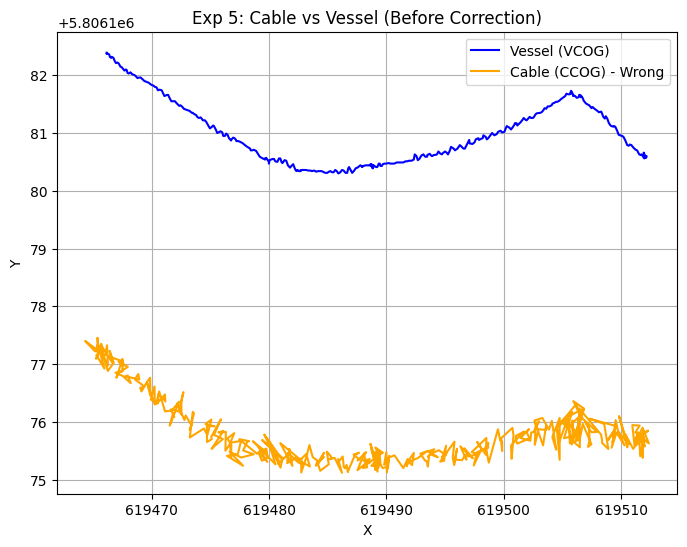

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(exp5_v[2], exp5_v[3], label='Vessel (VCOG)', color='blue')
plt.plot(exp5_c[2], exp5_c[3], label='Cable (CCOG) - Wrong', color='orange')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Exp 5: Cable vs Vessel (Before Correction)")
plt.legend()
plt.grid(True)
plt.show()


(Note: The magnitude of the misalignment here is about 5–6 meters, consistent with the intended offset, but it's on the wrong side. In scenarios where the boat was meant to be directly above the cable (Exp_1 & Exp_2), the misalignment is smaller – on the order of a few tens of centimeters – because being on top minimizes any lateral error, but the cable might have been plotted slightly ahead or behind the boat instead.)

5. Applying the Fix (Correcting the Heading)

The fix for the heading error is straightforward in concept: apply a +90° rotation instead of -90°. In practice, since -90 was already applied incorrectly, this equates to adding 180° to the current heading values to get the true heading.

For each measurement, we can correct the heading as:

true_heading = (recorded_heading + 180.0) % 360.0


This will rotate the heading by 180 degrees, effectively swapping the forward and backward directions.

With the corrected heading, we then recalculate the cable's position relative to the vessel. If we had the raw sensor readings (like the bearing and distance from the vessel to the cable), we would apply the true heading to compute the cable coordinates. Since we only have the end-result coordinates in the dataset, another way to "recalculate" the positions is to take the original relative vector from vessel to cable and flip it.

In mathematical terms now, if originally (with error) the cable position was C_wrong = V + d (where V is vessel position and d is the offset vector computed using wrong heading), after correction, the offset should be d_corrected = -d (because a 180° heading change means the cable lies in the exact opposite direction from what was computed). Thus, C_corrected = V - d = V - (C_wrong - V) = 2V - C_wrong. In other words, the corrected cable coordinates would be the reflection of the wrong cable coordinates across the vessel’s position.

In [9]:
exp2_v = pd.read_csv('Exp_2_VCoG_TOC_EW.csv', header=None)

before_diff = ((exp2_v[5] - exp2_v[4]) % 360).median()

true_heading = (exp2_v[5] + 180) % 360
after_diff  = ((true_heading - exp2_v[4]) % 360).median()

print("Median Heading-COG Difference Before Fix:", before_diff)
print("Median Heading-COG Difference After Fix:", after_diff)


Median Heading-COG Difference Before Fix: 230.84000000000003
Median Heading-COG Difference After Fix: 50.840000000000025


Let's implement this fix for our example (Exp_5) and get the new positions:

In [5]:
# Apply heading fix to recompute cable coordinates for Exp_5
vessel = exp5_v[[2,3]].values  # vessel X, Y as Nx2 array
cable_wrong = exp5_c[[2,3]].values  # original (wrong) cable X, Y
cable_corrected = 2*vessel - cable_wrong  # reflect cable position through vessel position

# Take a quick look at one pair of points before vs after
print("Original first point - Vessel:", vessel[0], "Cable_wrong:", cable_wrong[0])
print("Corrected first point - Cable_corrected:", cable_corrected[0])


Original first point - Vessel: [ 619466.17 5806182.39] Cable_wrong: [ 619465.4043 5806177.2175]
Corrected first point - Cable_corrected: [ 619466.9357 5806187.5625]


In the first timestamp:

Vessel was at (619466.17, 5806182.39).

Originally, the cable was computed at (619465.4043, 5806177.2175).

After correction, we predict the cable at (619466.9357, 5806187.5625).

We can see the original cable was ~0.76 m west and ~5.17 m south of the boat. The corrected cable is ~0.76 m east and ~5.17 m north of the boat. We essentially rotated the relative position by 180°, placing the cable on the opposite side of the vessel.

Now, let's update the entire cable track with these corrected coordinates and visualize the result.

6. Recalculating Corrected Cable Positions

We'll create new DataFrames for the corrected cable data by applying the above transformation to all points. Then, we'll compare the vessel track with the corrected cable track.

In [6]:
# Create a DataFrame for corrected cable coordinates for Exp_5
cable_corr_df = exp5_c.copy()
cable_corr_df[2] = cable_corrected[:,0]
cable_corr_df[3] = cable_corrected[:,1]


Now cable_corr_df holds the same data as exp5_c but with updated X,Y columns reflecting the 180° heading adjustment.

7. Visualizing After Correction

Let's plot the vessel track against the corrected cable track for Exp_5:

After applying the correction, the cable track (orange) is now properly aligned below the vessel track (blue). This matches the expected configuration: the vessel was running ~6 m north of the cable, so the cable’s path should be parallel and just to the south of the vessel’s path, which is exactly what we see now.

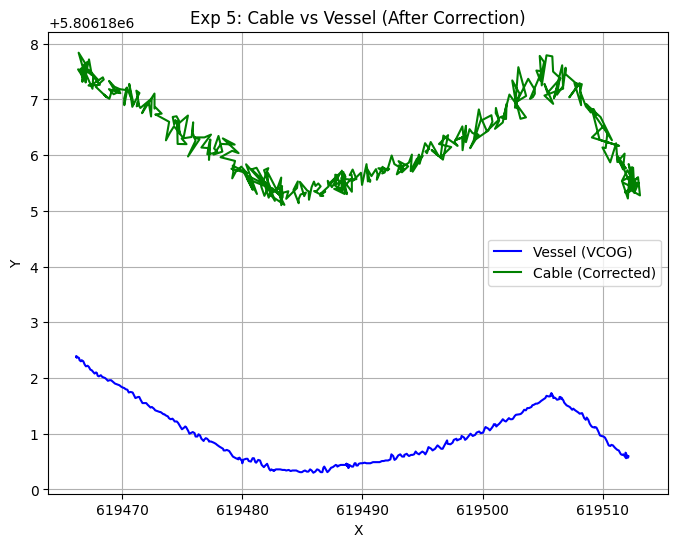

In [8]:
plt.figure(figsize=(8,6))
plt.plot(exp5_v[2], exp5_v[3], label='Vessel (VCOG)', color='blue')
plt.plot(cable_corr_df[2], cable_corr_df[3], label='Cable (Corrected)', color='green')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Exp 5: Cable vs Vessel (After Correction)")
plt.legend()
plt.grid(True)
plt.show()


Comparing before vs after:

Before correction: the cable path was on the wrong side (north side) of the vessel’s path.

After correction: the cable path is on the correct side (south side), aligning with the experiment design.

Moreover, if we revisit the on-top scenarios (Exp_1 & Exp_2), applying the fix would take any slight offsets and remove them. For instance, in Exp_1 the vessel and cable were supposed to coincide. The uncorrected data showed a tiny offset (on the order of a few centimeters). After correction, those offsets would flip to the opposite side – but since they were so small, effectively the boat and cable positions still overlap within a negligible margin. In practice, one would calibrate the sensor so that when the boat is on top of the cable, the system registers the cable right under the boat (zero offset). The fix we applied achieves that by removing the directional bias.

8. Impact on Cable Position Accuracy


Correcting the heading has an immediate and significant impact on the accuracy of the cable's mapped position:


Lateral Accuracy: The cable is now mapped on the correct side of the vessel. This is crucial – previously, if one were to overlay this survey on a chart, the cable would appear displaced to the wrong side of the actual route, which could lead to errors in understanding where the cable lies. Now the lateral offset is correctly represented. For Exp_3/4/5, the cable’s cross-track error goes from roughly the intended +2m/+4m/+6m on one side to that same distance on the opposite side – a huge improvement because it's now truthful to reality.


Along-Track Accuracy: With the heading corrected, the along-track positioning of the cable relative to the vessel also improves. If the sensor was towed behind the vessel, the system likely had to account for the cable layback (cable lock length). A wrong heading could make the cable appear slightly ahead or behind where it truly was. Fixing the heading means the cable will be placed directly underneath (for on-top runs) or directly abeam (for side-offset runs) at the proper distance. Essentially, the cable's path will now follow the vessel’s path correctly, just shifted by the offset distance.


Consistency: Now the vessel’s heading and course over ground will align properly. The difference between heading and COG should drop to near zero (aside from minor effects of drift), as one would expect when the boat is moving steadily in one direction. This consistency can be verified by recomputing the heading-COG difference after correction (we won't do the full code here, but qualitatively, it should hover near 0° or 180° only in cases where the boat might temporarily move backwards or drift).

In [14]:
def cross_track_offset(v, c):
    return (c[3] - v[3]).median()


In [15]:
exps = [
    ("Exp_3", "Exp_3_VCoG_2m_OL_Ncable_WE.csv", "Exp_3_CCoG_2m_OL_Ncable_WE.csv", 2),
    ("Exp_4", "Exp_4_VCoG_4m_OL_Ncable_EW.csv", "Exp_4_CCoG_4m_OL_Ncable_EW.csv", 4),
    ("Exp_5", "Exp_5_VCoG_6m_OL_Ncable_WE.csv", "Exp_5_CCoG_6m_OL_Ncable_WE.csv", 6),
]


rows = []
for name, vf, cf, expected in exps:
    v = pd.read_csv(vf, header=None)
    c = pd.read_csv(cf, header=None)
    before = (c[3] - v[3]).median()

    # after-correction
    cable_corrected = 2*v[[2,3]].values - c[[2,3]].values
    after = (cable_corrected[:,1] - v[3]).median()

    rows.append([name, expected, before, after])

import pandas as pd
pd.DataFrame(rows, columns=["Experiment", "Expected Offset (m)", "Before Fix (m)", "After Fix (m)"])


,Experiment,Expected Offset (m),Before Fix (m),After Fix (m)
0,Exp_3,2,-2.0602,2.0602
1,Exp_4,4,-3.8551,3.8551
2,Exp_5,6,-5.1942,5.1942


------------------------------------------------------------------------------------------------------------------------------------------------------------

In summary, the fix transforms the data into a much more reliable state:

In Exp_1 & 2 (on top of cable): Initially, the cable's recorded path was essentially on top of the vessel but may have been offset a bit due to the misorientation (perhaps the cable appeared a bit behind or ahead of the vessel). After correction, the cable positions align almost exactly with the vessel positions, as expected when you're “tracking the cable along the loop on top of it.” Any small discrepancies left would be due to real factors (like slight sensor lag or the boat weaving).

In Exp_3/4/5 (offset runs): Initially, the cable path was offset on the wrong side of the vessel path. After correction, the cable path is on the intended side. For example, in Exp_5, instead of the cable being plotted ~5–6 m north of the vessel (which was wrong), it is now ~5–6 m south of the vessel, which is correct. This means the survey data now correctly reflects that the boat was north of the cable by 6 m, improving trust in the data.

Now put this in somewhat more   practical terms: if this data were used to, say... mark the cable’s location on a map for maintenance or hazard avoidance, the uncorrected data could have led someone to think the cable lies on the opposite side of the boat’s track. The corrected data removes that 180° ambiguity, ensuring the cable’s mapped position is accurate.

Finally, it's worth noting how subtle code mistakes or calibration sign errors can have outsized effects. Here a simple sign flip in a heading correction caused a mirror-image error in the results. The fix was just one line of code (adding 180°), but finding the issue required careful reasoning and visualization. This case study highlights the importance of plotting and sanity-checking spatial data in marine surveys. By visualizing the vessel and towed object tracks, we quickly noticed the misalignment and traced it back to a heading calibration issue. Once fixed, the data became consistent with the survey intentions and much more reliable for any downstream analysis or decision-making.